# Test om koden er riktig implementert

Her er et forslag til testfunksjoner for å sjekke om koden er riktig implementert.
```assert variabel``` vil gi en feilmelding med mindre variabelen ```variabel = True```. For eksempel vil ```assert a == b``` gi en feilmelding med mindre ```a``` og ```b``` er like.

In [111]:
#For eksempel:
variable = True
assert variable, "You need to change 'variable' to True"

In [112]:
from layers import *
from neural_network import NeuralNetwork
from utils import onehot
import numpy as np
import matplotlib.pyplot as plt

In [113]:
#We choose some arbitrary values for the dimensions
b = 1
n_max = 7
m = 8
n = 5

d = 10
k = 5
p = 15

#Create an arbitrary dataset
x = np.random.randint(0, m, (b,n))
y = np.random.randint(0, m, (b,n_max))

#initialize the layers
feed_forward = FeedForward(d,p)
attention = Attention(d,k)
embed_pos = EmbedPosition(n_max,m,d)
un_embed = LinearLayer(d,m)
softmax = Softmax()


#a manual forward pass
X = onehot(x, m)
z0 = embed_pos.forward(X)
z1 = feed_forward.forward(z0)
z2 = attention.forward(z1)
z3 = un_embed.forward(z2)
Z = softmax.forward(z3) 



#check the shapes
assert X.shape == (b,m,n), f"X.shape={X.shape}, expected {(b,m,n)}"
assert z0.shape == (b,d,n), f"z0.shape={z0.shape}, expected {(b,d,n)}"
assert z1.shape == (b,d,n), f"z1.shape={z1.shape}, expected {(b,d,n)}"
assert z2.shape == (b,d,n), f"z2.shape={z2.shape}, expected {(b,d,n)}"
assert z3.shape == (b,m,n), f"z3.shape={z3.shape}, expected {(b,m,n)}"
assert Z.shape == (b,m,n), f"Z.shape={Z.shape}, expected {(b,m,n)}"

#is X one-hot?
assert X.sum() == b*n, f"X.sum()={X.sum()}, expected {b*n}"


assert np.allclose(Z.sum(axis=1), 1), f"Z.sum(axis=1)={Z.sum(axis=1)}, expected {np.ones(b)}"
assert np.abs(Z.sum() - b*n) < 1e-5, f"Z.sum()={Z.sum()}, expected {b*n}"
assert np.all(Z>=0), f"Z={Z}, expected all entries to be non-negative"


In [114]:

#test the forward pass
n_y = n_max - 1
x = np.random.randint(0, m, (b,n_max))
X = onehot(x, m)

#we test with a y that is shorter than the maximum length
y = np.random.randint(0, m, (b,n_y))

#initialize a neural network based on the layers above
network = NeuralNetwork([embed_pos, feed_forward, attention, un_embed, softmax])
#and a loss function
loss = CrossEntropy()

N = 10000
#do a forward pass
for i in range(N):
    Z = network.forward(X)

    #compute the loss
    L = loss.forward(Z, y)
    if not (i%(N//10)):
        print(L)

    #get the derivative of the loss wrt Z
    grad_Z = loss.backward()

    #and perform a backward pass
    _ = network.backward(grad_Z)

    #and and do a gradient descent step
    _ = network.step_gd(0.1)

2.213758714615147
9.398032717607625e-05
4.250698527892641e-05
2.6868095777794967e-05
1.9438406160277417e-05
1.513410117615994e-05
1.2340557826945004e-05
1.0388030380068066e-05
8.950055801186499e-06
7.849006931166511e-06


In [115]:
def training(neuralNetwork, objectFunction, dataSet, nIter, m, alpha = 0.01, beta_1 = 0.9, beta_2 = 0.999):
    L = []
    for i in range(nIter):
        for batchNumber, x in enumerate(dataSet[0]):
            X = onehot(x,m)
            Z = neuralNetwork.forward(X)
            L.append(objectFunction.forward(Z,dataSet[1][batchNumber]))
            grad_Z = objectFunction.backward()
            neuralNetwork.backward(grad_Z)
            neuralNetwork.adamStep(i, batchNumber, len(dataSet[0]), alpha = alpha, beta_1 = beta_1, beta_2 = beta_2)
    return neuralNetwork, L
            

In [116]:
def generateSortData(numberOfBatches, batchSize, n_max, m):
    x = np.random.randint(0,m,(numberOfBatches,batchSize, (n_max+1)//2))
    y = np.sort(x, axis = 2)
    x = np.append(x,y, axis = 2)[:,:,:-1]
    return [x,y]

In [140]:
nBatches = 10
batchSize = 250
n_max = 9
m = 8
n_iter = 500
feed_forward = FeedForward(d,p)
attention = Attention(d,k)
feed_forward2 = FeedForward(d,p)
attention2 = Attention(d,k)
embed_pos = EmbedPosition(n_max,m,d)
un_embed = LinearLayer(d,m)
softmax = Softmax()
network = NeuralNetwork([embed_pos, feed_forward, attention, feed_forward2, attention2, un_embed, softmax])
loss = CrossEntropy()
dataSet = generateSortData(nBatches, batchSize, n_max, m)
network,L = training(network, loss, dataSet, n_iter, m, alpha = 0.001)



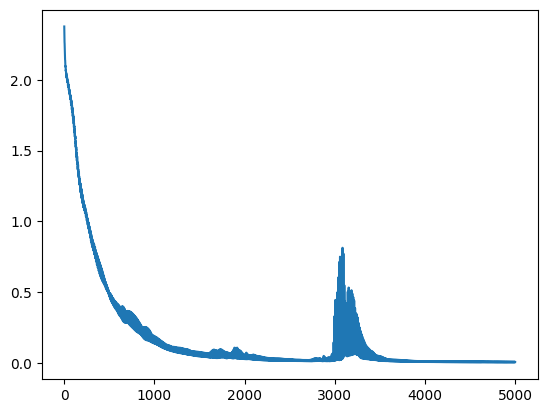

0.005469332142190055
97.39999999999999


In [142]:
fig, ax = plt.subplots()
ax.plot(np.arange(0,len(L),1), L)
plt.show()
print(L[-1])
N = 1000
y = np.random.randint(0,m,(N,5))
s = np.copy(y)
s = np.sort(s, axis = 1)
for i in range(5):
    z = np.argmax(network.forward(onehot(y,m)), axis = 1)
    y = np.append(y, z[:,-1:], axis = 1)
y = y[:,5:]
t = 0
for i in range(len(s)):
    equal = True
    for j in range(len(s[i])):
        if s[i,j] != y[i,j]:
            equal = False
    if equal:
        t += 1
print(t/N*100)

In [119]:
"""
Here you may add additional tests to for example:

- Check if the ['d'] keys in the parameter dictionaries are not None, or receive something when running backward pass
- Check if the parameters change when you perform a gradient descent step
- Check if the loss decreases when you perform a gradient descent step

This is voluntary, but could be useful.
"""

"\nHere you may add additional tests to for example:\n\n- Check if the ['d'] keys in the parameter dictionaries are not None, or receive something when running backward pass\n- Check if the parameters change when you perform a gradient descent step\n- Check if the loss decreases when you perform a gradient descent step\n\nThis is voluntary, but could be useful.\n"

In [120]:
#check if loss is non-negative
assert L[-1] >= 0, f"L={L}, expected L>=0"
assert grad_Z.shape == Z.shape, f"grad_Z.shape={grad_Z.shape}, expected {Z.shape}"

#check if onehot(y) gives zero loss
Y = onehot(y, m)
L = loss.forward(Y, y)
assert L < 1e-5, f"L={L}, expected L<1e-5"


TypeError: '>=' not supported between instances of 'list' and 'int'